# Exploratory Data Analysis (EDA) Part II

The purpose of this notebook is to analyze pairwise variable relationships based on domain knowledge and observations of the data. In other words, this is equivalent to the **EXPLORE** step in the Green Cloud Model. In addition, we will emphasize our target variable (variable we intend to forecast) and narrow down the list of variables to the top 10 variables based whatever variables we deem are redundant or irrelevant from **ONE** data table, which will be selected based on what we learned from single variable analysis on all three data tables. We will continue to use the selected data stored in the MySQL analysis table and modify as needed, similar to Part I. 

In [1]:
%matplotlib inline

In [2]:
import pymysql
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import statsmodels.api as sm

import eda
%run -i 'eda.py'

sns.set(style="whitegrid")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

<a id="00"></a>
### Notebook Contents

1. [Create Table Copy](#0)
2. [Pairwise Relationship Exploration](#1)
    - [median_sale_price vs. period_begin, state, property_type](#a)
    - [median_sale_price vs. median_list_price](#d)
    - [median_sale_price vs. median_ppsf](#e)
    - [median_sale_price vs. median_list_ppsf](#f)
    - [median_sale_price vs. homes_sold](#g)
    - [median_sale_price vs. pending_sales](#h)
    - [median_sale_price vs. new_listings](#i)
    - [median_sale_price vs. inventory](#j)
    - [median_sale_price vs. months_of_supply](#k)
    - [median_sale_price vs. median_dom](#l)
    - [median_sale_price vs. price_drops](#n)
    - [median_sale_price vs. off_market_in_two_weeks](#o)


<a id="0"></a>
### Create Table Copy

[Back to Contents](#00)

Since the goal of this project is centered around the data science process, I prefer to avoid automating machine learning processes too excessively in this case (i.e. regression via Spark). Based on EDA Part I, we noted that the National table tended to miss trends present in the State and County tables, since there are no regional features. In addition, the County table is very dense and can be difficult to visualize; the County table was unable to provide any additional information or trends that we didn't notice in the State table beforehand. Therefore, we will focus on the State data for any forecasting, model building, and further analysis. 


In [3]:
conn = pymysql.connect(
    host= 'MySQL_1',
    port=3306,
    user="Sarah",
    passwd='password',
    db="db",
    charset='utf8mb4')

In [4]:
curs = conn.cursor()

In [5]:
# State table in pandas
curs.execute("SHOW columns FROM State_analysis")
state_analysis_headers = [column[0] for column in curs.fetchall()]

curs.execute("SELECT * FROM State_analysis \
              ORDER BY period_begin ASC")
state = pd.DataFrame(curs.fetchall(), columns=state_analysis_headers)

<a id="1"></a>
### Pairwise Relationship Exploration

[Back to Contents](#00)

In addition to selecting a single data table, we will also reevaluate the features we have to determine which ones  we want to move forward with. Although there are machine learning techniques that can be applied, we will focus on using **domain knowledge** and our analysis of the features so far to determine what features to maintain. Why would we do it this way? Generating a correlation matrix or running PCA are potential options, but they make us **blind**, since we can't tell if our results "make sense" which can result in a lot of time wasted. This is why a a methodological approach to EDA is so important. 

For the State table, the `region` variable will not be evaluated, since it is exactly the same as `state`, as noted in Part I. We will also only use period_begin, since it is redundant with period_end, and we will only use `state` instead of `state_code`. Every other variable will be compared to our target variable, `median_sale_price`.

<a id="a"></a>
#### median_sale_price vs. period_begin, state, property_type

[Back to Contents](#00)

For the first pairwise exploration section, we will compare median sale price and three other variables. Although we usually want to do each variable one by one, in this case, there are five entries for each time point (each with a median sale price) for each of the states. Therefore, we cannot effectively visualize the median sale price over time without separating them by the state and property types since each sub-group is an individual time series. This will become more clear when we try visualizing the median sale price over time for a few of the states. 

Based on domain knowledge, we would expect the median sale price to increase overtime as the value of homes increases. In addition, we expect the median sale price to climb faster in high cost of living states. We expect the property type to have varying influence on the median sale price since it depends on each state, i.e. New York may have greater condo prices because of NYC compared to Oklahoma. Currently, dates are stored in the MySQL database as YYYY-MM-DD but there are multiple data points for each date; specifically, there is one row for each state and residence type. 

Before jumping into the time series visualizations for several states, we will first look at median_sale_price and property_type by comparing the basic statistics for each category.

In [6]:
describe_by_category(state, "median_sale_price", "property_type", transpose=True)

property_type,All Residential,Condo/Co-op,Multi-Family (2-4 Unit),Single Family Residential,Townhouse
count,5950.00,5816.00,5698.00,5950.00,5323.00
mean,254368.05,211510.56,244329.78,270675.01,248510.50
std,112464.33,105795.44,179133.04,137878.73,166874.10
min,78100.00,49300.00,11000.00,80200.00,10900.00
25%,177700.00,142800.00,127525.00,183900.00,155000.00
50%,222550.00,184800.00,193400.00,232050.00,198800.00
75%,296400.00,241150.00,303850.00,312600.00,276450.00
max,850700.00,929700.00,2165000.00,1275000.00,2920000.00


The mean's for each property type are not significantly different; Single residential families sell for the most on average while condo's or co-ops sell for the least on average. Across all residential properties, homes sold for $254,368.05 on average. Townhouses are, on average, the second most expensive residence type, even when compared to multi family. Using common domain knowledge, town houses are very expensive in cities where single family homes and multi-family homes are not possible or are very rare, so this makes sense.

All of the property sub-groups have right skewed distributions since the mean is greater than the median and these values sit closer to the minimum in all cases. Next, we can generate a multi-box plot to compare the distributions of each sub-group of the median sale prices by property type:

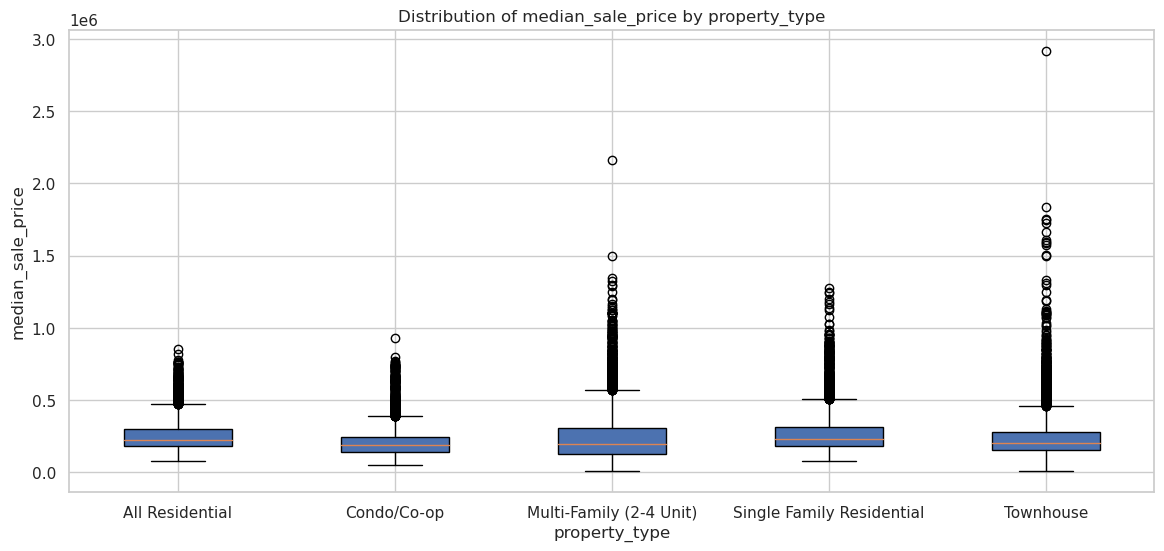

In [7]:
multiboxplot(state, "median_sale_price", "property_type")

Besides a few outliers, most of the distributions are somewhat similar. Condo's are generally cheaper with a tighter distribution compared to multi-family and single-family homes. Townhouses have the most dispersed distribution, which makes sense since townhouses are common expensive properties in cities but are still present in lower cost of living areas. 

Comparing each state by finding the basic statistics for the median sale price would be difficult since we have nearly 50 states/categories (it will be hard to visualize 50 box plots...). Therefore, we can group the dataframe by state code and property type so we can attempt to visualize the prices over time for individual time series and avoid treating each state like an individual category.

In [8]:
state_grouped = state.groupby(['state_code', "property_type"])

state_keys = list(state_grouped.groups.keys())

state_keys

[('AK', 'All Residential'),
 ('AK', 'Condo/Co-op'),
 ('AK', 'Multi-Family (2-4 Unit)'),
 ('AK', 'Single Family Residential'),
 ('AL', 'All Residential'),
 ('AL', 'Condo/Co-op'),
 ('AL', 'Multi-Family (2-4 Unit)'),
 ('AL', 'Single Family Residential'),
 ('AL', 'Townhouse'),
 ('AR', 'All Residential'),
 ('AR', 'Condo/Co-op'),
 ('AR', 'Multi-Family (2-4 Unit)'),
 ('AR', 'Single Family Residential'),
 ('AR', 'Townhouse'),
 ('AZ', 'All Residential'),
 ('AZ', 'Condo/Co-op'),
 ('AZ', 'Multi-Family (2-4 Unit)'),
 ('AZ', 'Single Family Residential'),
 ('AZ', 'Townhouse'),
 ('CA', 'All Residential'),
 ('CA', 'Condo/Co-op'),
 ('CA', 'Multi-Family (2-4 Unit)'),
 ('CA', 'Single Family Residential'),
 ('CA', 'Townhouse'),
 ('CO', 'All Residential'),
 ('CO', 'Condo/Co-op'),
 ('CO', 'Multi-Family (2-4 Unit)'),
 ('CO', 'Single Family Residential'),
 ('CO', 'Townhouse'),
 ('CT', 'All Residential'),
 ('CT', 'Condo/Co-op'),
 ('CT', 'Multi-Family (2-4 Unit)'),
 ('CT', 'Single Family Residential'),
 ('CT', 

In [9]:
len(state_keys)

238

We are dealing with a lot of potential visualizations, so we can focus in on six states just to get an idea of what the trends over time looked like. They should be similar for most states even if the range of median sale prices and the rate of price increase are different.

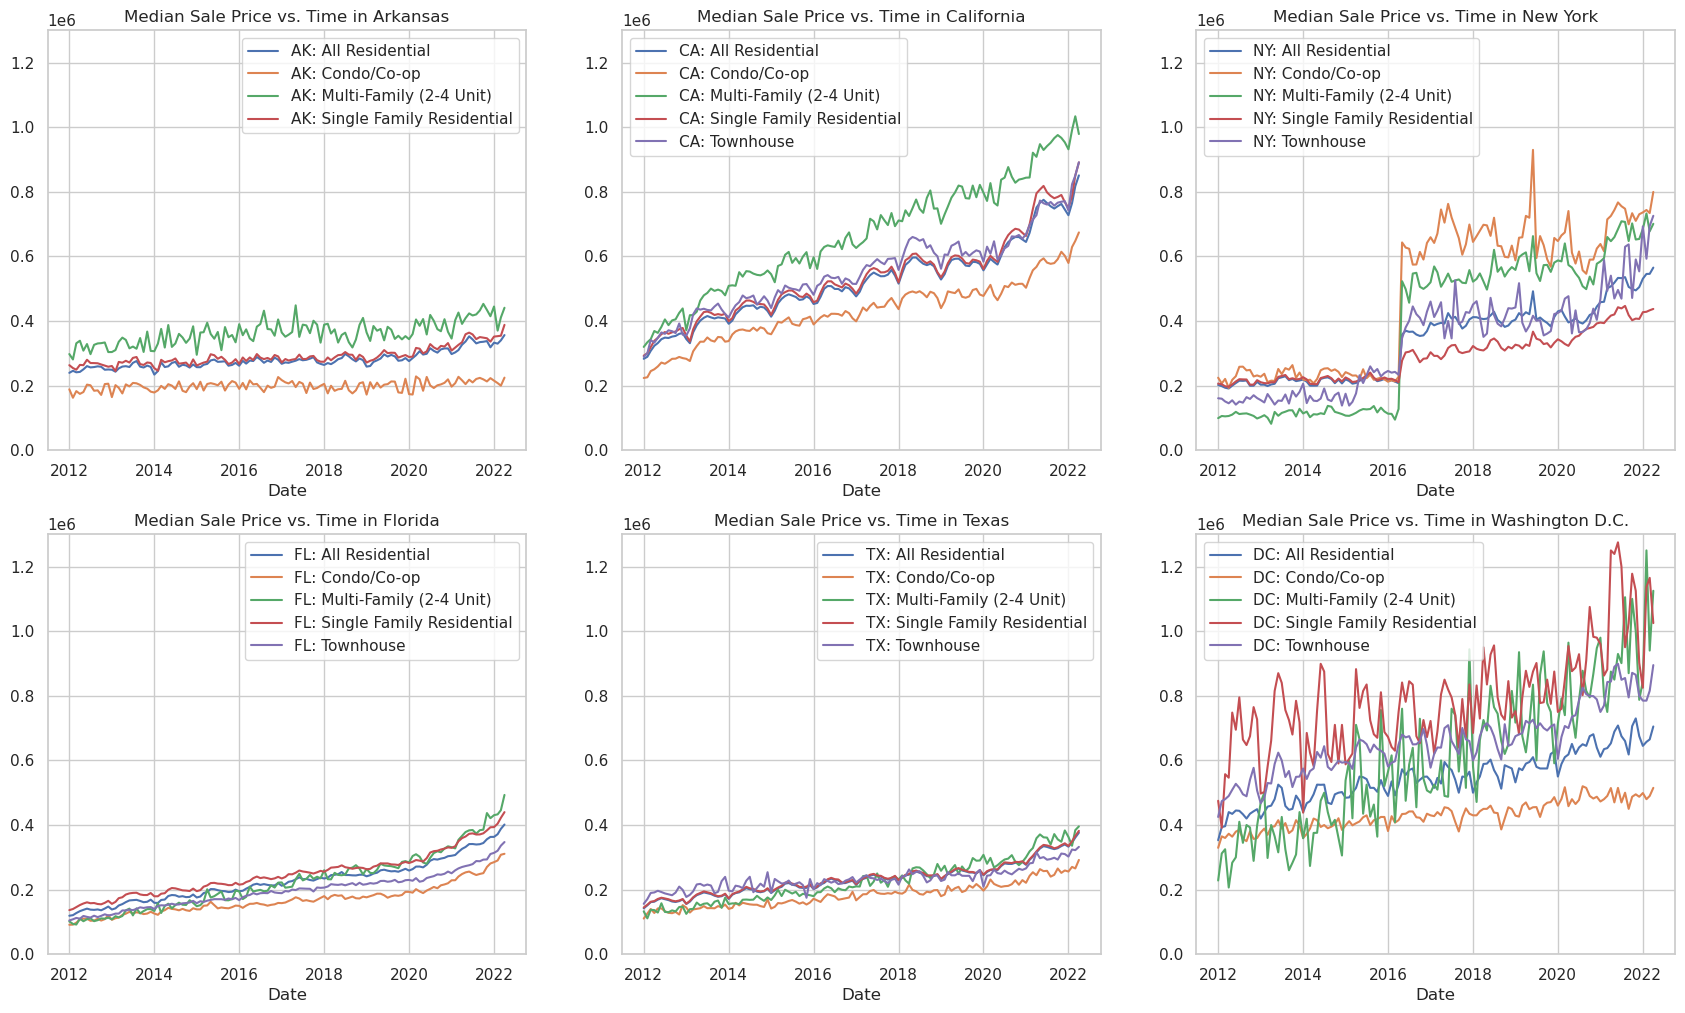

In [10]:
figure = plt.figure(figsize=(21, 12))

# Arkansas : Townhouse data not available
axes = figure.add_subplot(2, 3, 1)
legend_ = []

for i in range(0, 4):
    df = state_grouped.get_group(state_keys[i])
    legend_.append(f"{state_keys[i][0]}: {state_keys[i][1]}")
    axes.plot(df.period_begin, df.median_sale_price)

axes.set_ylim(0, 1300000)
axes.legend(legend_)
axes.set_title("Median Sale Price vs. Time in Arkansas")
axes.set_xlabel("Date")

# California
axes = figure.add_subplot(2, 3, 2)
legend_ = []

for i in range(19, 24):
    df = state_grouped.get_group(state_keys[i])
    legend_.append(f"{state_keys[i][0]}: {state_keys[i][1]}")
    axes.plot(df.period_begin, df.median_sale_price)

axes.set_ylim(0, 1300000)
axes.legend(legend_)
axes.set_title("Median Sale Price vs. Time in California")
axes.set_xlabel("Date")

# New York
axes = figure.add_subplot(2, 3, 3)
legend_ = []

for i in range(159, 164):
    df = state_grouped.get_group(state_keys[i])
    legend_.append(f"{state_keys[i][0]}: {state_keys[i][1]}")
    axes.plot(df.period_begin, df.median_sale_price)

axes.set_ylim(0, 1300000)
axes.legend(legend_)
axes.set_title("Median Sale Price vs. Time in New York")
axes.set_xlabel("Date")

# Florida
axes = figure.add_subplot(2, 3, 4)
legend_ = []

for i in range(44, 49):
    df = state_grouped.get_group(state_keys[i])
    legend_.append(f"{state_keys[i][0]}: {state_keys[i][1]}")
    axes.plot(df.period_begin, df.median_sale_price)

axes.set_ylim(0, 1300000)
axes.legend(legend_)
axes.set_title("Median Sale Price vs. Time in Florida")
axes.set_xlabel("Date")

# Texas
axes = figure.add_subplot(2, 3, 5)
legend_ = []

for i in range(204, 209):
    df = state_grouped.get_group(state_keys[i])
    legend_.append(f"{state_keys[i][0]}: {state_keys[i][1]}")
    axes.plot(df.period_begin, df.median_sale_price)

axes.set_ylim(0, 1300000)
axes.legend(legend_)
axes.set_title("Median Sale Price vs. Time in Texas")
axes.set_xlabel("Date")

# Washington D.C.
axes = figure.add_subplot(2, 3, 6)
legend_ = []

for i in range(34, 39):
    df = state_grouped.get_group(state_keys[i])
    legend_.append(f"{state_keys[i][0]}: {state_keys[i][1]}")
    axes.plot(df.period_begin, df.median_sale_price)

axes.set_ylim(0, 1300000)
axes.legend(legend_)
axes.set_title("Median Sale Price vs. Time in Washington D.C.")
axes.set_xlabel("Date")

plt.show()

Looking at six states at random, we can note that the median sale price increases in the long run for all states but at varying degrees. For example, Florida and Texas display a steady increase in median sale price for all property types over time but the rate of increase is not as extreme as California or New York. It's interesting to see the sharp increase in New York versus the steady increase in California since we naturally may expect both states to have a steady, high increase in median price over time rather than a sudden increase in 2016. Since this sharp increase is present in all five property types, we can assume the median sale prices for New York are true. 

The pairwise relationship between median sale price and time, when we consider each property type, is expected and straightforward, other than cases, like New York, where the trends do not follow a steady rate of increase. This can be something we keep in mind when building the forecasting model, since it's very likely that other states display similar *unexpected* trends. 

<a id="d"></a>
#### median_sale_price vs. median_list_price
[Back to Contents](#00)

Naturally, we expect the median sale price and median list price to follow very closely. One thing we noticed during the single variable exploration was the difference between sale and list over the 10 year period. Specifically, the median list price is 10-20k more than the median sale price, on average. Other than that, we should see high spearman and pearson correlation coefficients indicating strong, positive linear and monotonic relationships between the variables.

In [11]:
eda.correlate(state.median_sale_price, state.median_list_price)

r   =  0.8428561315132008
rho =  0.8697599677152168


As indicated by the pearson's coefficient of 0.84 and the spearman's coefficient of 0.87, these two variables have a strong, positive linear and monotonic relationship.  

Let's generate a scatter plot with a small amount of jitter to depict this relationship:

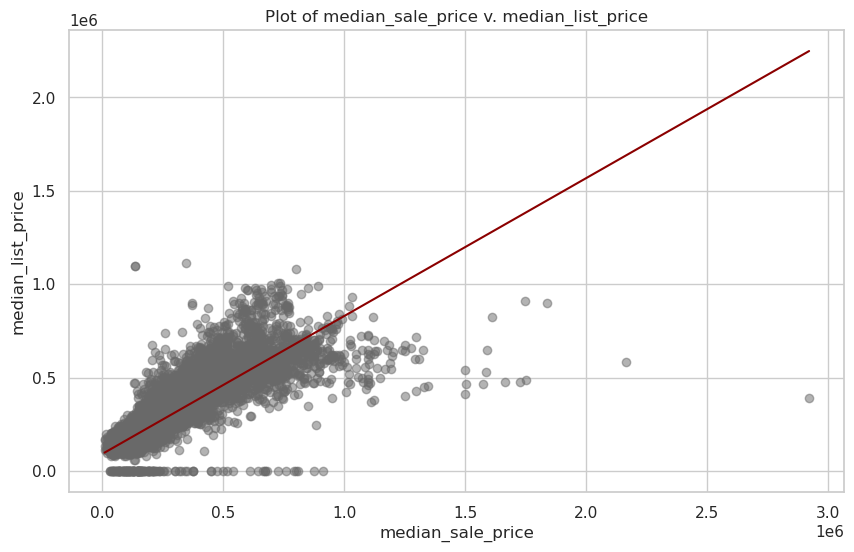

In [12]:
lowess_scatter(state, "median_sale_price", "median_list_price", jitter=0.1, skip_lowess=True)

Although the strong, positive relationship expected is obvious in the scatter plot, we do have a few other points to draw from the visualization. First, we do seem to have a few outliers for median_sale_price which do not correlate with their respective list prices. Second, we have a cluster of values in median_list_price that sit at zero and do not align with their respective median sale prices. These values would be valid to drop since a median list price of zero, in this case where there is a median sale price, does not make sense. However, we could opt to calculate the missing values using an imputation method such as K-Nearest Neighbor(KNN). 

Let's look at the rows that make up the zero value median_list_price's:

In [13]:
curs.execute("SELECT * FROM State_analysis \
              WHERE median_list_price = 0 \
              ORDER BY median_sale_price ASC;")

result = pd.DataFrame(curs.fetchall(), columns=state_analysis_headers)

print(len(result))
result

147


,id,period_begin,period_end,period_duration,region_type,table_id,region,state,state_code,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,price_drops,off_market_in_two_weeks
0,3417,2012-06-01,2012-06-30,30,state,46,West Virginia,West Virginia,WV,Multi-Family (2-4 Unit),32000.00,0.00,0.00,0.00,3.00,1.00,0.00,8,2.70,39.00,0.00,0.00
1,22626,2013-04-01,2013-04-30,30,state,41,Maine,Maine,ME,Multi-Family (2-4 Unit),34000.00,0.00,0.00,0.00,2.00,0.00,0.00,0,0.00,0.00,0.00,0.00
2,10362,2013-01-01,2013-01-31,30,state,41,Maine,Maine,ME,Multi-Family (2-4 Unit),35800.00,0.00,0.00,0.00,2.00,0.00,0.00,0,0.00,0.00,0.00,0.00
3,2299,2016-02-01,2016-02-29,30,state,15,Delaware,Delaware,DE,Multi-Family (2-4 Unit),42200.00,0.00,0.00,0.00,8.00,3.00,0.00,61,7.60,71.00,0.08,0.00
4,19978,2013-02-01,2013-02-28,30,state,41,Maine,Maine,ME,Multi-Family (2-4 Unit),42800.00,0.00,0.00,0.00,5.00,0.00,0.00,0,0.00,0.00,0.00,0.00
5,10326,2013-09-01,2013-09-30,30,state,41,Maine,Maine,ME,Multi-Family (2-4 Unit),45000.00,0.00,0.00,0.00,7.00,0.00,0.00,0,0.00,0.00,0.00,0.00
6,15452,2014-03-01,2014-03-31,30,state,41,Maine,Maine,ME,Multi-Family (2-4 Unit),46700.00,0.00,0.00,0.00,6.00,0.00,0.00,0,0.00,0.00,0.00,0.00
7,13148,2016-06-01,2016-06-30,30,state,1,Alabama,Alabama,AL,Multi-Family (2-4 Unit),47000.00,0.00,0.00,0.00,7.00,3.00,0.00,4,0.60,229.00,0.00,0.00
8,21801,2013-02-01,2013-02-28,30,state,41,Maine,Maine,ME,Condo/Co-op,49300.00,0.00,0.00,0.00,5.00,0.00,0.00,0,0.00,0.00,0.00,0.00
9,15878,2016-07-01,2016-07-31,30,state,47,Michigan,Michigan,MI,Townhouse,50000.00,0.00,0.00,0.00,1.00,1.00,0.00,1,1.00,24.00,1.00,0.00


There are only 147 rows out of nearly 30,000 rows that contain zero for the median_list_price. In addition, median_ppsf and median_list_ppsf are zero for these rows as well. Therefore, missing value imputation will be difficult, especially if we depend on these features since they likely have the highest correlation coefficients with each other. Therefore, we need to drop these rows from the table.

In [14]:
curs.execute("DELETE FROM State_analysis \
              WHERE median_list_price = 0;")

147

In [15]:
curs.execute("SELECT * FROM State_analysis \
              ORDER BY period_begin ASC")
              
state = pd.DataFrame(curs.fetchall(), columns=state_analysis_headers)

<a id="e"></a>
#### median_sale_price vs. median_ppsf
[Back to Contents](#00)

Based on domain knowledge and single variable exploration, we expect the median_ppsf to have a strong, positive monotonic relationship with median_sale_price, especially when we consider property_type. The likelihood of a strong linear relationship depends on how significant the property_type variable is in median ppsf. We can start with the correlation coefficients as follows:

In [16]:
eda.correlate(state.median_sale_price, state.median_list_price)

r   =  0.8546259357410266
rho =  0.875173494195251


Based on the pearson's correlation coefficient of 0.843, these two variables have a strong, positive linear relationship. In addition, the spearman's coefficient of 0.87 indicates an even stronger monotonic relationship, meaning property_type likely plays a role i.e. condo has greater ppsf compared to a single family home based on location. Let's generate the scatter plot:

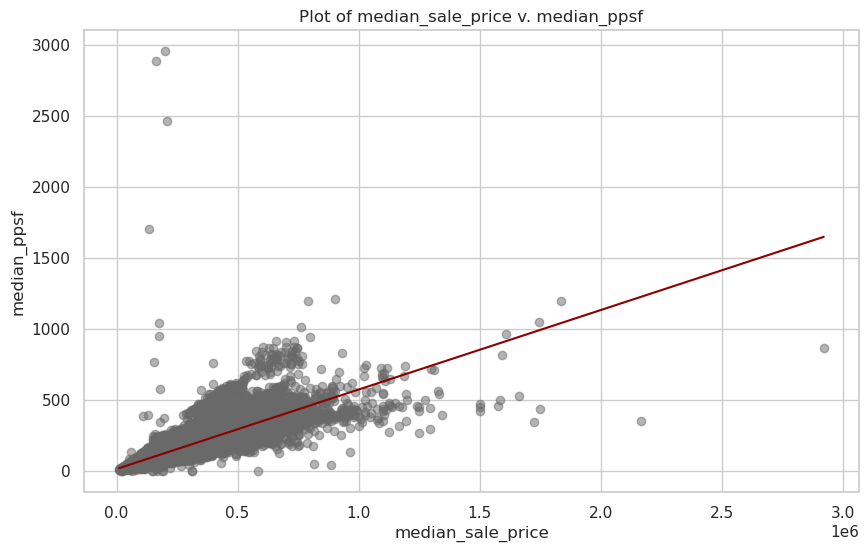

In [17]:
lowess_scatter(state, "median_sale_price", "median_ppsf", jitter=0.1, skip_lowess=True)

Overall, the relationship aligns with the results from the correlation coefficients; these variables display a strong, positive linear and monotonic relationship which logically makes sense and aligns with domain knowledge/single variable exploration. In addition, there are no obvious clusters that indicate missing values which means the previous decision to drop the 147 "problem" rows with three missing values was helpful for the all price related variables (at least so far).

<a id="f"></a>
#### median_sale_price vs. median_list_ppsf
[Back to Contents](#00)

Based on domain knowledge and our experience so far with these variables, we can predict that the correlation coefficients between median_sale_price and median_list_ppsf indicate that the variables are strongly correlated with a positive linear and monotonic relationship. In addition, we may see some outliers and a cluster at zero median_list_ppsf since we saw these occurrences when we compared median sale price against other numeric variables so far.  

In [18]:
eda.correlate(state.median_sale_price, state.median_list_ppsf)

r   =  0.8317310364733741
rho =  0.8532538351895321


As predicted, there is a strong, positive linear relationship between median sale price and median list ppsf, as indicated by the pearson's correlation coefficient of 0.83. There is an even stronger, positive monotonic relationship between these variables, as indicated by the spearman's correlation coefficient of 0.85. 

We can generate the scatter plot and see if any notable outliers are still present after we dropped the missing values previously:

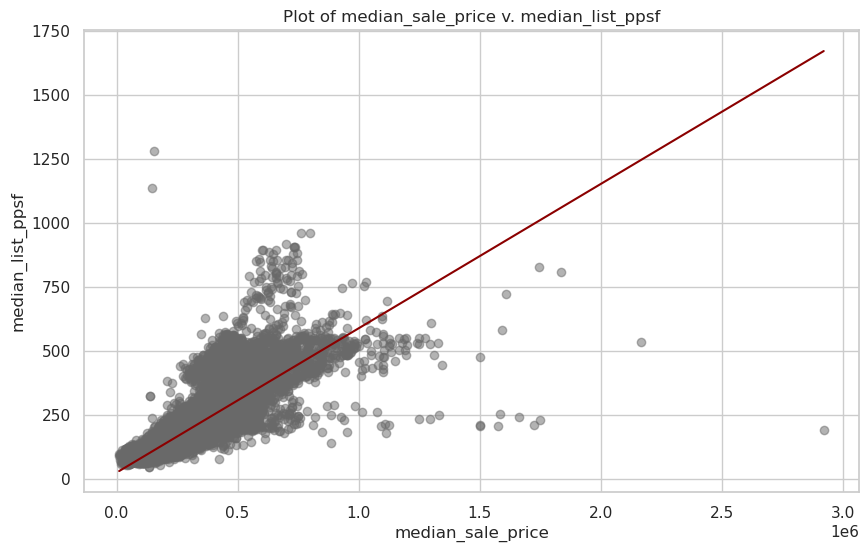

In [19]:
lowess_scatter(state, "median_sale_price", "median_list_ppsf", jitter=0.1, skip_lowess=True)

We have a handful of outliers for both median sale price, as seen previously, and median list ppsf. Otherwise, we can see a clear strong, positive linear and monotonic relationship between both variables. 

<a id="g"></a>
#### median_sale_price vs. homes_sold
[Back to Contents](#00)

Unlike the pairwise relationships so far, median sale price and homes sold may have a weaker relationship because the number of homes sold in a region may be due to chance or other factors rather than market conditions that affect home prices. We can start with the correlation coefficients:

In [20]:
eda.correlate(state.median_sale_price, state.homes_sold)

r   =  0.13734864750643924
rho =  0.27853389952251656


As suspected, there is a weak, positive linear relationship between these two features based on the pearson's coefficient of 0.14. In addition, there is a slightly stronger monotonic relationship based on the spearman's coefficient of 0.28, although the monotonic relationship is still on the weaker side. There are likely other variables influencing the degree of influence that homes_sold has on the median sale price, such as the state. For example, a sudden drop in the number of homes sold in a high demand state like New York could push the price even higher due to housing shortages, while a drop in a less popular state could be due to lack of interest which would push prices lower. 

Let's generate the scatter plot:

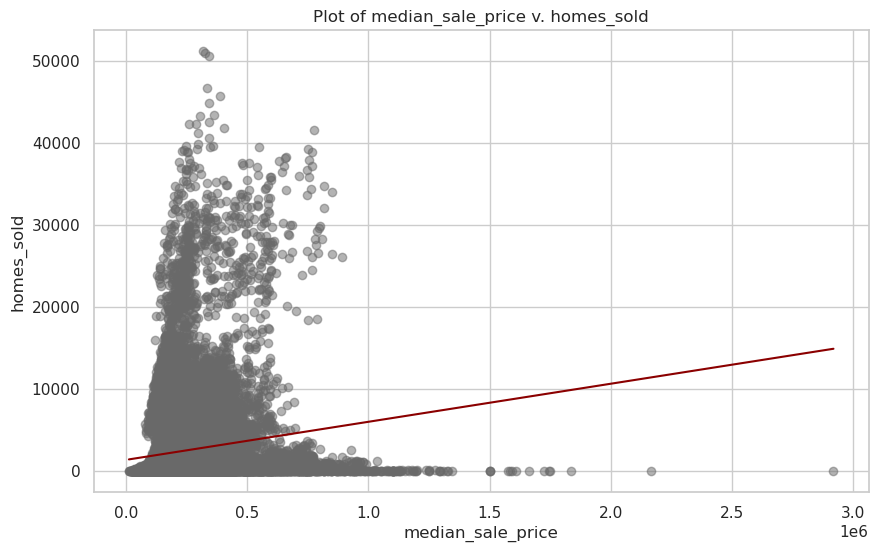

In [21]:
lowess_scatter(state, "median_sale_price", "homes_sold", jitter=0.1, skip_lowess=True)

Based on the scatter plot, the relationship between these two variables seems weak overall. Remember from Part I where we did the single variable exploration, the values along the x-axis are just small values (i.e. <100) but they are not zero. Therefore, they are **not** incorrect or missing values. The median sale price for these rows are based on a very small cohort of homes that were sold. It's possible this variable would benefit from an interaction term if we were to perform linear regression, so we will keep this in mind. 

<a id="h"></a>
#### median_sale_price vs. pending_sales
[Back to Contents](#00)

Based on the weak relationship between median_sale_price and homes_sold, we can predict that pending_sales will also have a weak relationship with median_sale_price. We can start with the correlation coefficients:

In [22]:
eda.correlate(state.median_sale_price, state.pending_sales)

r   =  0.17568943846530313
rho =  0.3401216061071415


There is a weak, positive linear relationship, as indicated by the Pearson's coefficient of 0.18, and a somewhat median monotonic relationship, as indicated by the Spearman's coefficient of 0.34. This aligns with expectations, so we can move on to the scatter plot:

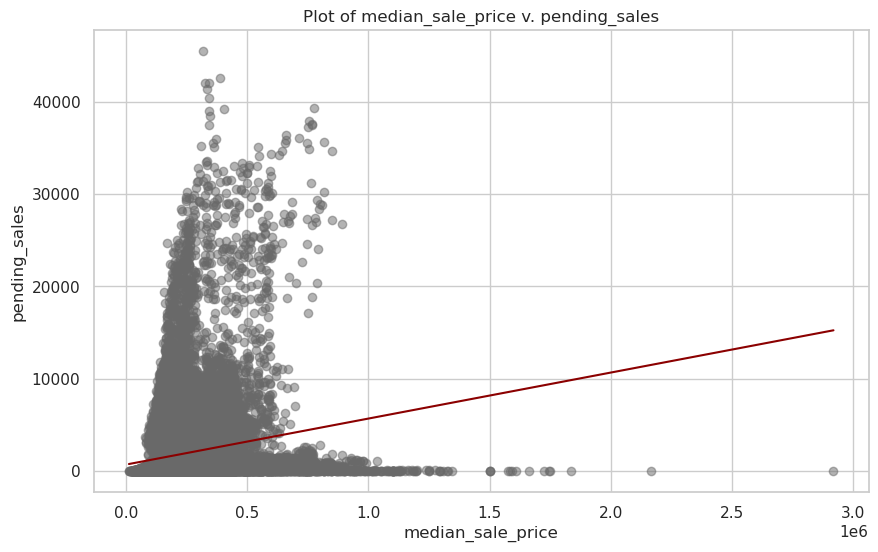

In [23]:
lowess_scatter(state, "median_sale_price", "pending_sales", jitter=0.1, skip_lowess=True)

The scatter plot is shaped very similarly to the scatter plot between median_sale_price and homes_sold. Therefore, pending_sales may also benefit from a transformation or interaction term if we wanted to generate a linear regression model.

<a id="i"></a>
#### median_sale_price vs. new_listings
[Back to Contents](#00)

Similar to homes_sold and pending_sales, median_sale_price and new_listings likely have a weak linear and weak monotonic relationship since we expect any of the count features to correlate with one another. The pearson's and spearman's correlation coefficients are as follows:

In [24]:
eda.correlate(state.median_sale_price, state.new_listings)

r   =  0.12590602574609383
rho =  0.2652674204402601


There is a weak, positive linear relationship based on the pearson's coefficient of 0.13 and a slightly stronger, positive monotonic relationship based on the spearman's coefficient of 0.27. This is expected, so we can assume the shape in the scatter plot will be similar to the previous count related features we explored:

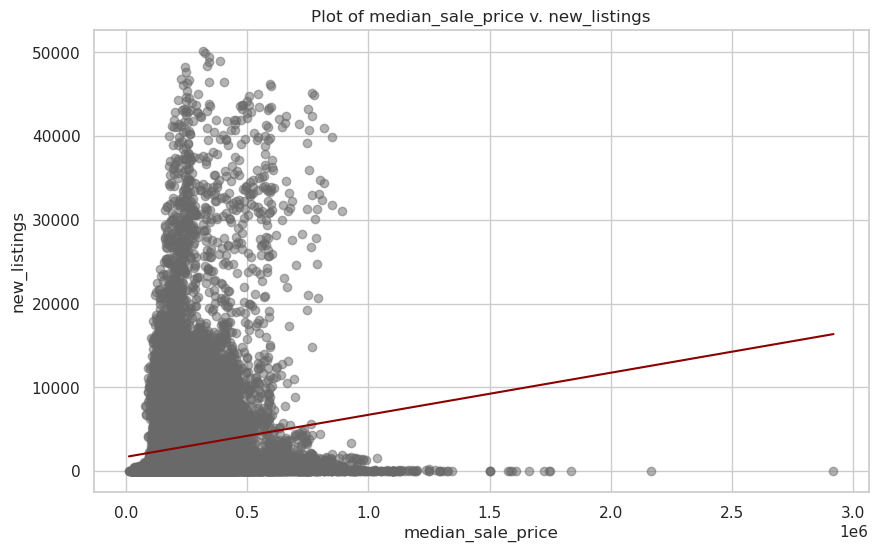

In [25]:
lowess_scatter(state, "median_sale_price", "new_listings", jitter=0.1, skip_lowess=True)

As stated previously, new_listings may benefit from some kind of transformation or incorporation in an interaction term if we developed a regression based model since the monotonic relationship is decently stronger than the linear relationship in this pairwise comparison. 

<a id="j"></a>
#### median_sale_price vs. inventory
[Back to Contents](#00)

Once again, we are dealing with a "count" related feature so we expect the pairwise relationship to behave similarly to the last few relationships. Specifically, inventory won't directly influence the sale price a *majority* of the time since inventory will affect various states very differently; i.e. popular states with low inventory may see price increases due to shortages and high demand while less popular states will see the opposite occur.

The correlation coefficients are as follows:

In [26]:
eda.correlate(state.median_sale_price, state.inventory)

r   =  0.0344155756496972
rho =  0.18706815376959185


There is a very weak, positive linear relationship based on the pearson's coefficient of 0.04 and a slightly stronger, positive monotonic relationship based on the spearman's coefficient of 0.19. Although this is somewhat expected, we can note that the relationship between inventory and sale price is even weaker than the other count variables that were based on actual sales (sold or pending sale) or new listings. Therefore, we can expect the scatter plot to have a similar shape to previous pairwise relationships with some discrepancies:

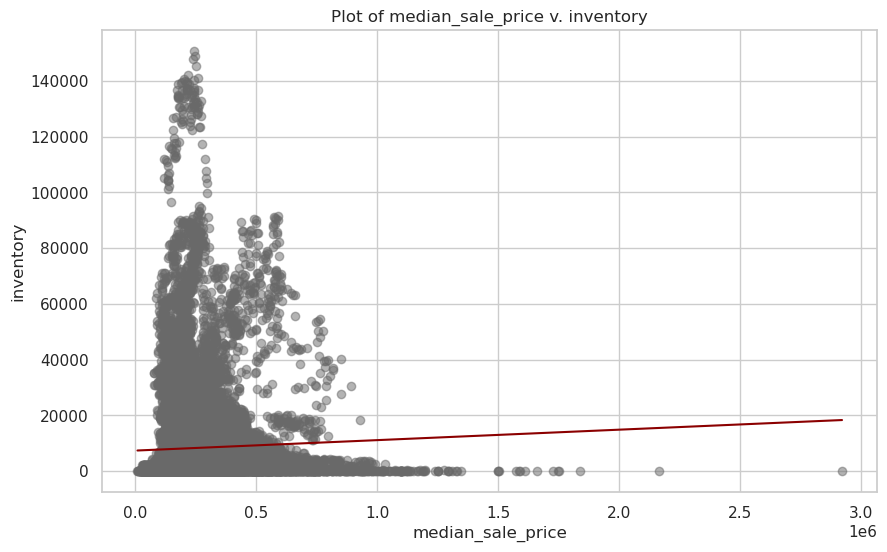

In [27]:
lowess_scatter(state, "median_sale_price", "inventory", jitter=0.1, skip_lowess=True)

When comparing the scatter plot here with the previous few scatter plots, we can note that there is a cluster of points near the average median sale price that has much higher inventory counts. This is likely what is affecting the correlation coefficients for this pairwise relationship relative to the previous coefficients in the last few pairwise relationships. Like before, this variable can benefit from a transformation or interaction term if we develop a regression model in order to correct residuals for a better fit. 

<a id="k"></a>
#### median_sale_price vs. months_of_supply
[Back to Contents](#00)

We expect the respective pairwise relationship with median_sale_price to be relatively weak, but it's hard to predict if the relationship is positive or negative. Once again, it may be dependent on other variables, such as location, where:

```
less months of supply = increase in demand = increase in median_sale_price 
```
or...
```
less months of supply = less interest in supply = decrease in median_sale_price
```

Let's generate the correlation coefficients:

In [28]:
eda.correlate(state.median_sale_price, state.months_of_supply)

r   =  -0.19212852998124835
rho =  -0.34636703408464775


As expected, the linear and monotonic relationships between median_sale_price and months_of_supply are relatively weak. However, it is surprising that the relationship is negative for both the linear and monotonic relationships. That implies that the relationship weakly leans towards a situation where
less months of supply results in increase in median_sale_price. We can generate the scatter plot to see if this relationship seems evident visually:


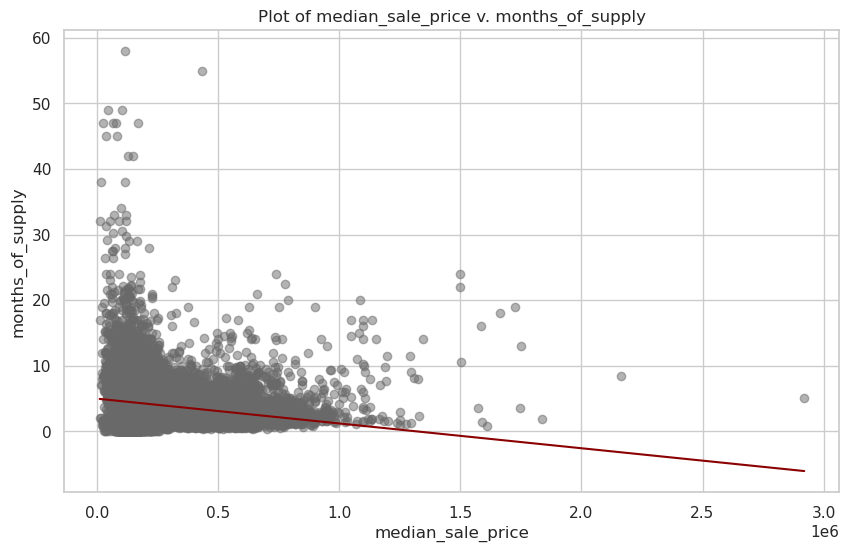

In [29]:
lowess_scatter(state, "median_sale_price", "months_of_supply", jitter=0.1, skip_lowess=True)

Based on the scatter plot, there is an evident negative relationship but it seems much more non-linear. An interaction term, like a term with homes_sold which would indicate if the low month of supply is due to high or low demand, or a transformation on the variable would likely help increase the coefficients.

<a id="l"></a>
#### median_sale_price vs. median_dom
[Back to Contents](#00)

Median_dom is very similar to months of supply, in that more days on the market means more months of supply. They are both time based features and both displayed similar distributions when we did single variable exploration. Therefore, we expect the respective pairwise relationships to behave similarly.

In [30]:
eda.correlate(state.median_sale_price, state.median_dom)

r   =  -0.18722654304568456
rho =  -0.397768797443138


As predicted, we have similar correlation coefficients as the pairwise relationship we investigated with months_of_supply. There is a weak, negative linear relationship based on the pearson's coefficient of -0.19 and a stronger, negative monotonic relationship based on the spearman's coefficient of -0.40. Let us generate the scatter plot: 

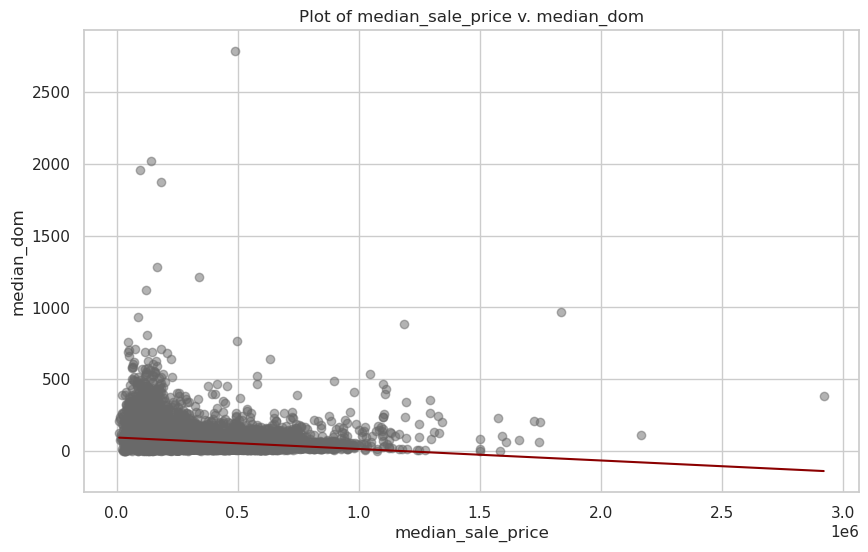

In [31]:
lowess_scatter(state, "median_sale_price", "median_dom", jitter=0.1, skip_lowess=True)

The scatter plot is "tighter" along the trend line compared to what we saw with months of supply, but overall, the overall trend of the pairwise relationship appears similar. As median days on the market decreases, the median sale price increases. This variable will likely benefit from an interaction term or transformation due to the stronger non-linear relationship. 

<a id="n"></a>
#### median_sale_price vs. price_drops
[Back to Contents](#00)

Based on domain knowledge, we can predict that as the proportion of price drops increases, the median_sale_price may increase or decrease depending on other variables. Specifically, there may be cases on both ends of the spectrum:

```
high demand location = homes listed very expensive = proportion of price drops increases = median sale price increases
```
or
```
low demand location = proportion of price drops increases = median sale price decreases
```

In these two cases, the main difference is **why** the proportion of price drops is high in the respective state. On one hand, very expensive homes tend to have more price drops to attract buyers or during negotiations but the final sale price is still high and the demand limits how much the price is decreased. On the other hand, low demand areas need price drops to attract buyers even though the price is already low, signalling difficulty finding potential buyers. 

Let's generate the correlation coefficients:

In [32]:
eda.correlate(state.median_sale_price, state.price_drops)

r   =  0.30775335042796753
rho =  0.3833623165440902


There is a weak-medium linear relationship, as indicated by the Pearson's coefficient of 0.31, and a stronger monotonic relationship, as indicated by the Spearman's coefficient of 0.38. In both cases, the relationships are positive (increases in one means an increase in the other). Next, we can generate the scatter plot:

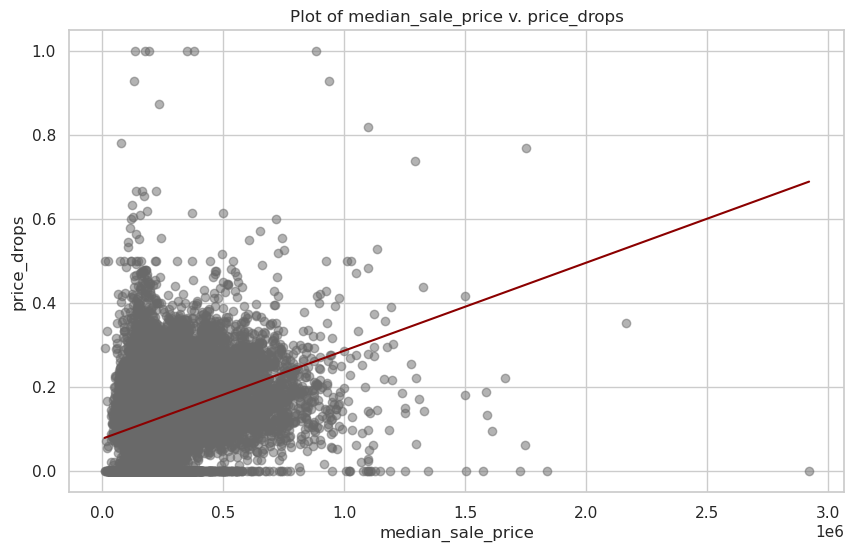

In [33]:
lowess_scatter(state, "median_sale_price", "price_drops", jitter=0.1, skip_lowess=True)

We can see a slight linear relationship in the scatter plot, but it is very likely that we will need transformations to correct non-equal variance in the residuals, which is evident by the *fanning* out seen in the scatter plot, as well as interaction terms to factor in variables of influence if we create any regression models. 

<a id="o"></a>
#### median_sale_price vs. off_market_in_two_weeks
[Back to Contents](#00)

We can predict that median_sale_price and off_market_in_two_weeks would have a weak to medium linear and monotonic relationship, with the monotonic relationship being stronger. Based on what we have seen so far, it's far more likely that off_market_in_two weeks has a more non-linear relationship with median_sale_price since it will also vary based on location. For some locations, a higher proportion of homes leaving the market may result in shortages that increase median sale price but other locations may have an opposite effect. 

The correlation coefficients are as follows:

In [34]:
eda.correlate(state.median_sale_price, state.off_market_in_two_weeks)

r   =  0.2699645380714783
rho =  0.34888222515804


There is a weak, positive linear relationship, as indicated by the Pearson's coefficient of 0.27, and a weak-medium, positive monotonic relationship, as indicated by the Spearman's coefficient of 0.35. Next, we can generate the scatter plot:

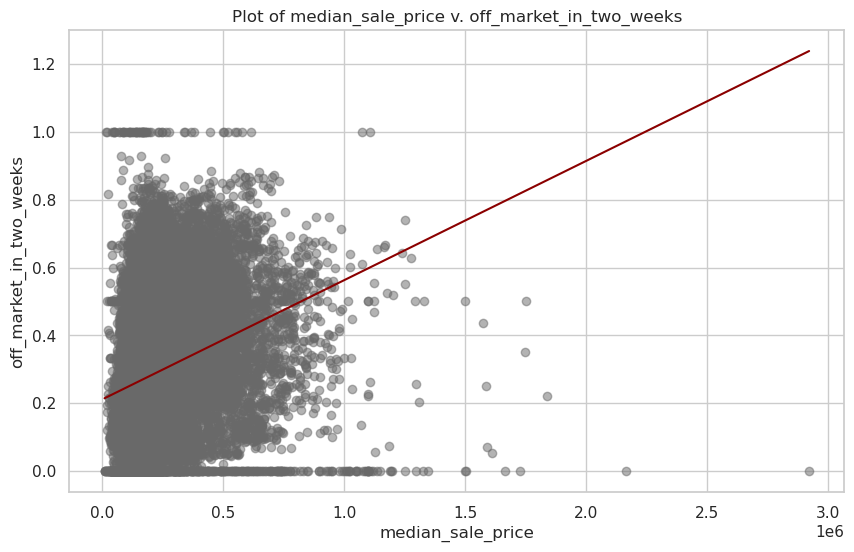

In [35]:
lowess_scatter(state, "median_sale_price", "off_market_in_two_weeks", jitter=0.1, skip_lowess=True)

Based on the scatter plot, it's difficult to say if the clusters at 0% and 100% are affecting the correlation coefficients, especially the pearson's coefficient. There does not seem to be an obvious linear relationship, based on the visualization. Therefore, we are likely dealing with a non-linear relationship that would benefit from a transformation, such as a log transformation, and/or an interaction term with a variable like median_dom (median days on the market) if we opt for a regression model.